<a href="https://colab.research.google.com/github/Jonathan-Chia/mmm-research/blob/main/bayesian_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import xarray as xr

## Generate Simulated Data

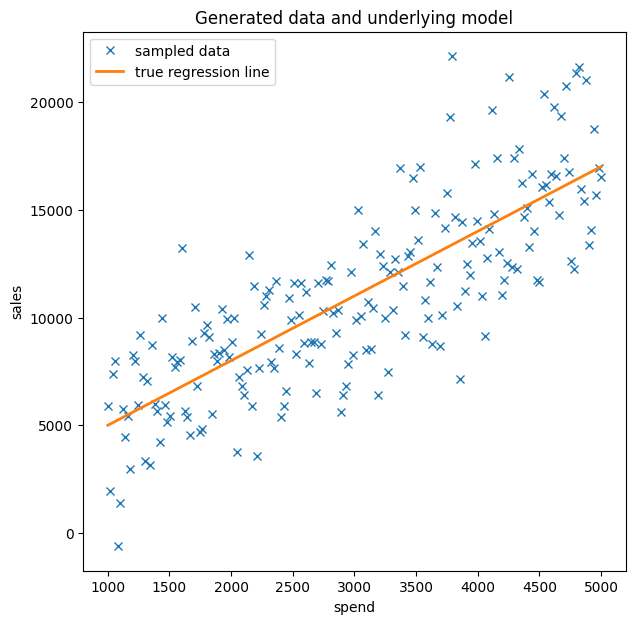

In [2]:
size = 200
true_intercept = 2000
true_slope = 3
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


spend = np.linspace(1000, 5000, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * spend
# add noise
sales = true_regression_line + rng.normal(scale=3000, size=size)

data = pd.DataFrame({"spend": spend, "sales": sales})

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="spend", ylabel="sales", title="Generated data and underlying model")
ax.plot(spend, sales, "x", label="sampled data")
ax.plot(spend, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [3]:
!pip install pymc

In [4]:
import pymc as pm
print('Running on the PyMC v{}'.format(pm.__version__))

Running on the PyMC v5.25.1


## Model and Priors set up

Here's the model formula:

$$ y_i \sim N(X_i^T \beta, \sigma^2) $$

In [5]:
with pm.Model() as bm:

    #Priors
    alpha = pm.Normal('alpha',0, sigma=10000) # intercept
    beta = pm.HalfNormal('beta', sigma=10) # slope
    sigma = pm.HalfNormal('sigma', sigma=4000) # standard deviation

    # Deterministics
    mu = alpha + beta*spend # intercept + Beta*spend

    # Likelihood
    Ylikelihood = pm.Normal('Ylikelihood', mu, sigma, observed=sales)

    # Prior predictive check
    idata = pm.sample_prior_predictive(samples=500)

Run a prior predictive check to see if my priors are reasonable.

Shape of y_prior before squeeze: (1, 500, 200)
Shape of y_prior after squeeze: (500, 200)


/tmp/ipython-input-586473704.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
/tmp/ipython-input-586473704.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)


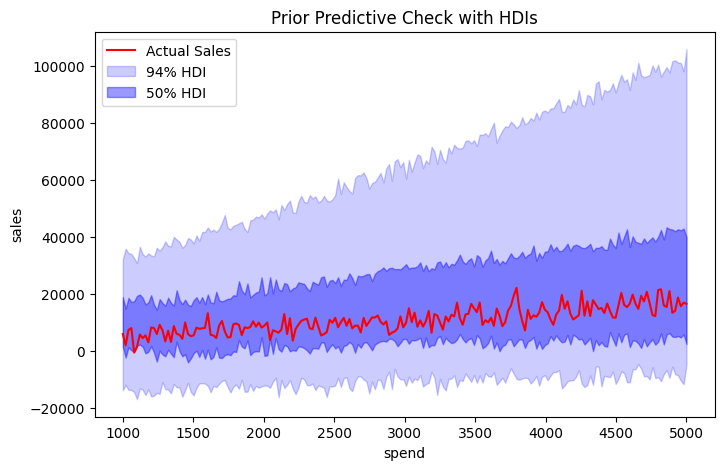

In [6]:
# Extract predictions
y_prior = idata.prior_predictive["Ylikelihood"].values
print(f"Shape of y_prior before squeeze: {y_prior.shape}")

# Remove the extra dimension of size 1
y_prior_squeezed = np.squeeze(y_prior)
print(f"Shape of y_prior after squeeze: {y_prior_squeezed.shape}")

hdi_94 = az.hdi(y_prior_squeezed, hdi_prob=0.94)
hdi_50 = az.hdi(y_prior_squeezed, hdi_prob=0.50)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(spend, sales, color="red", label="Actual Sales")
plt.fill_between(spend, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI")
plt.fill_between(spend, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI")
plt.title("Prior Predictive Check with HDIs")
plt.xlabel("spend")
plt.ylabel("sales")
plt.legend()
plt.show()

Looks reasonable, so let's fit the model and then look at the model parameters!

## Model Fit

Output()

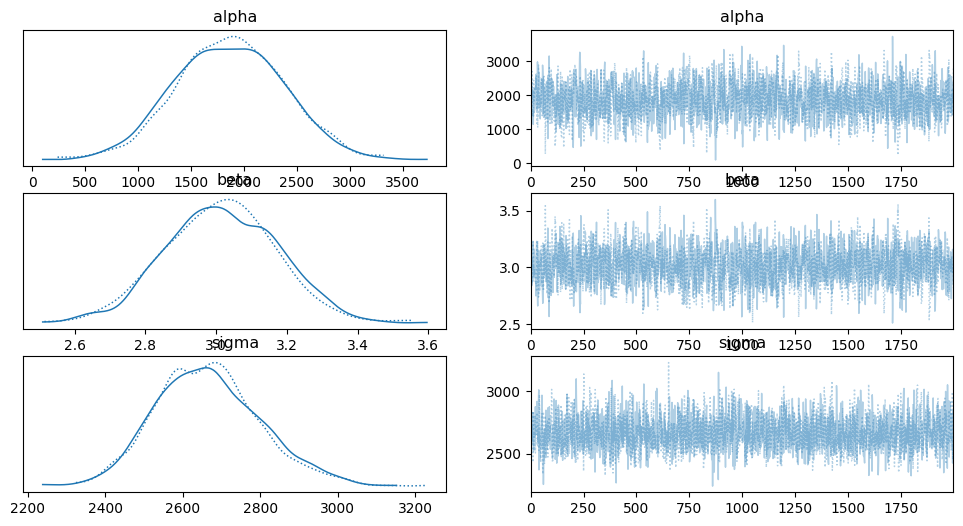

In [7]:
with bm:
    idata.extend(pm.sample(2000, tune=2000, random_seed=rng))

az.plot_trace(idata);

Looks like the model recovered our true values:

The alpha is centered close to around our true intercept of 2000.

The beta (second plot) is centered around the true slope of 3.

The sigma plot is a bit off, centered around 2700 when the real sigma was 3000.

## Predictions

In [8]:
with bm:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Output()

In [9]:
idata.posterior["y_model"] = idata.posterior["alpha"] + idata.posterior["beta"] * xr.DataArray(spend)

Shape of y_model_numpy: (2, 2000, 200)
Shape of y_mean: (200,)
Type of hdi_94: <class 'numpy.ndarray'>
Shape of hdi_94: (200, 2)
Type of hdi_50: <class 'numpy.ndarray'>
Shape of hdi_50: (200, 2)


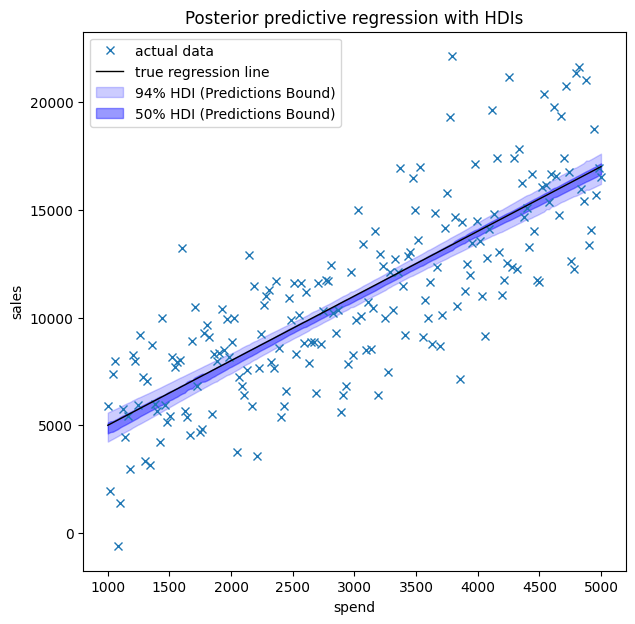

In [15]:
_, ax = plt.subplots(figsize=(7, 7))

# Plot the actual data points
ax.plot(spend, sales, "x", label="actual data")

# Posterior predictive regression lines
y_model_samples = idata.posterior["y_model"]  # shape: (chains, draws, observations)

# Convert to NumPy array for az.hdi
y_model_numpy = y_model_samples.values
print(f"Shape of y_model_numpy: {y_model_numpy.shape}")

# Compute mean and HDIs across posterior samples using the numpy array
y_mean = np.mean(y_model_numpy, axis=(0, 1)) # Mean across chains (axis 0) and draws (axis 1)
print(f"Shape of y_mean: {y_mean.shape}")


hdi_94 = az.hdi(y_model_numpy, hdi_prob=0.94)
hdi_50 = az.hdi(y_model_numpy, hdi_prob=0.50)


print(f"Type of hdi_94: {type(hdi_94)}")
print(f"Shape of hdi_94: {hdi_94.shape}")
print(f"Type of hdi_50: {type(hdi_50)}")
print(f"Shape of hdi_50: {hdi_50.shape}")


# Plot mean line
ax.plot(spend, true_regression_line, label="true regression line", lw=1, color='black')

# Plot HDI intervals as bands
ax.fill_between(spend, hdi_94[:, 0], hdi_94[:, 1], color="blue", alpha=0.2, label="94% HDI (Predictions Bound)")
ax.fill_between(spend, hdi_50[:, 0], hdi_50[:, 1], color="blue", alpha=0.4, label="50% HDI (Predictions Bound)")

ax.set_title("Posterior predictive regression with HDIs")
ax.set_xlabel("spend")
ax.set_ylabel("sales")
ax.legend()
plt.show()

Great! Looks like the model fit the data very well. We slightly underpredicted the true regression line, but it's within the hdi intervals.